### **Dataset:** 
Sentiment140 : discover the sentiment of a brand, product, or topic on Twitter.: http://help.sentiment140.com/for-students

This dataset has two file csv, one is trainingset "training.1600000.processed.noemoticon.csv" and one is for test "testdata.manual.2009.06.14.csv"
    "

### **Read data from SQLite** 

#### Import librairies

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from termcolor import colored

#### Load data

In [2]:
import sqlite3
import pandas as pd
# Create your connection.
cnx = sqlite3.connect('TwitterDB.db') # name of database qui store file sentiment140.csv

df = pd.read_sql_query("SELECT * FROM sentiment140", cnx) #sentiment140 is name of table qui store file sentiment140.csv
df.columns = ['target','id','date','flag','user','text']

In [3]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#### Shape and information of dataset

This dataset has 6 columns and 1600000 tweets

In [4]:
df.shape

(1600000, 6)

In [5]:
df.info

<bound method DataFrame.info of          target          id                          date      flag  \
0             0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1             0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2             0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3             0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4             0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1599995       4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
0        _TheSpecialOne_  @switchfoot

Types of each columns

In [6]:
df.dtypes

target     int64
id         int64
date      object
flag      object
user      object
text      object
dtype: object

In [7]:
df['target'].unique() #target in dataset

array([0, 4])

Although the description of dataset( target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive), we don't have tweets with target "2". So we can replace target from [0,4] by [0,1]

In [8]:
df['target'] = df.iloc[:, 0].replace(4,1)


In [9]:
df['target'].unique() #target in dataset, 0=negative, 4=positive

array([0, 1])

### **Plot data** 

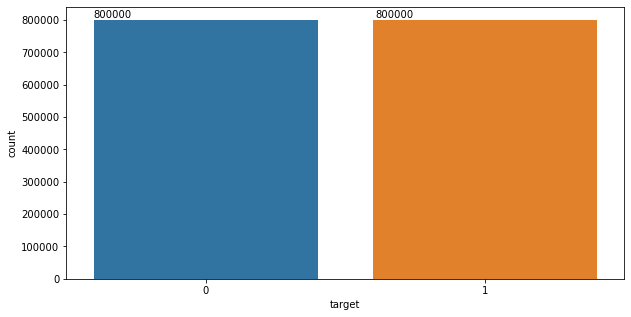

In [10]:
import seaborn as sns
plt.figure(figsize = (10,5))
ax=sns.countplot(x='target', data=df)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01 , p.get_height() * 1.01))

### **Data processing**

We need text of tweets and target. 

Spliting data to features and target


In [11]:
X = df['text']
X.head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3       my whole body feels itchy and like its on fire
4    @nationwideclass no, it's not behaving at all....
Name: text, dtype: object

In [12]:
y = df['target']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

In [13]:
from nltk.corpus import stopwords
STOPWORDS=stopwords.words('english')
STOPWORDS[:5]

['i', 'me', 'my', 'myself', 'we']

In [14]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
X = X.apply(lambda text: cleaning_stopwords(text))
X.head()

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    upset can't update Facebook texting it... migh...
2    @Kenichan I dived many times ball. Managed sav...
3                     whole body feels itchy like fire
4    @nationwideclass no, behaving all. i'm mad. he...
Name: text, dtype: object

In [18]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
#!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
X= X.apply(lambda x: cleaning_punctuations(x))
X.head()

0    switchfoot httptwitpiccom2y1zl  Awww thats bum...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: text, dtype: object

In [19]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
X= X.apply(lambda x: cleaning_repeating_char(x))
X.head()

0    switchfoot httptwitpiccom21zl  Awww thats bumm...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: text, dtype: object

In [21]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
X= X.apply(lambda x: cleaning_URLs(x))
X.head()


0    switchfoot httptwitpiccom21zl  A s bummer You ...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: text, dtype: object

In [22]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
X= X.apply(lambda x: cleaning_numbers(x))
X.head()

0    switchfoot httptwitpiccomzl  A s bummer You sh...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: text, dtype: object

In [23]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
X= X.apply(lambda x: stemming_on_text(x))
X.head()

0    switchfoot httptwitpiccomzl  A s bummer You sh...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: text, dtype: object

In [26]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /home/thi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/thi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [29]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
X= X.apply(lambda x: lemmatizer_on_text(x))
X.head()


0    switchfoot httptwitpiccomzl  A s bummer You sh...
1    upset cant update Facebook texting it might cr...
2    Kenichan I dived many times ball Managed save ...
3                     whole body feels itchy like fire
4    nationwideclass no behaving all im mad here I ...
Name: text, dtype: object

### **Splitting the data for Classification**

In [30]:
#ratio 80:20 for trainingset and testingset
train_X, test_X, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, shuffle=True)

print(f'Number of training examples: {len(train_X)}')
print(f'Number of testing examples: {len(test_X)}')

Number of training examples: 1280000
Number of testing examples: 320000
